In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import torch
import random
import numpy as np
from torchvision import datasets, transforms , models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb
from tqdm.notebook import tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [5]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

def get_dataloaders(data_dir, batch_size=32, val_split=0.2, augment=False, image_size=(224, 224), whole_train = False):
    """
    Loads the iNaturalist dataset, applies transformations, and splits the training set while maintaining class balance.
    Parameters:
        data_dir (str): Path to dataset containing 'train' and 'test' folders.
        batch_size (int): Batch size for DataLoader.
        val_split (float): Fraction of training data to use for validation.
        augment (bool): Whether to apply data augmentation to training data only.
        image_size (tuple): Target image size for resizing.
    Returns:
        train_loader, val_loader, test_loader, tiny_loader
    """

    # Define transforms
    basic_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4712, 0.4600, 0.3896], std=[0.1935, 0.1877, 0.1843])
    ])

    augmented_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4712, 0.4600, 0.3896], std=[0.1935, 0.1877, 0.1843])
    ]) if augment else basic_transform

    # Load full training set with basic transform just to get labels
    base_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=basic_transform)

    # Stratified split
    train_indices, val_indices = stratified_split(base_dataset, val_split)

    # Separate datasets using different transforms
    train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=augmented_transform)
    # if whole_train:
    #     test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=basic_transform)
    #     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)
    #     test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=g)
    #     return train_loader , test_loader

        
    val_dataset   = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=basic_transform)

    train_subset = Subset(train_dataset, train_indices)
    val_subset   = Subset(val_dataset, val_indices)
    tiny_train   = Subset(train_subset, indices=range(512))
    
    test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=basic_transform)

    g = torch.Generator()
    g.manual_seed(42)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, generator=g)
    val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False, generator=g)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=g)
    tiny_loader  = DataLoader(tiny_train, batch_size=16, shuffle=True, generator=g)

    return train_loader, val_loader, test_loader, tiny_loader

def stratified_split(dataset, val_split):
    """
    Splits dataset into training and validation sets with class balance.
    """
    labels = np.array(dataset.targets)
    train_indices, val_indices = train_test_split(
        np.arange(len(labels)), test_size=val_split, stratify=labels, random_state=42
    )
    return train_indices, val_indices


In [6]:
data_dir = "/kaggle/input/nature-12k/inaturalist_12K"  # Replace with your dataset path
train_loader, val_loader, test_loader, tiny_loader = get_dataloaders(data_dir, augment=True)

torch.Size([3, 224, 224])
tensor(1)


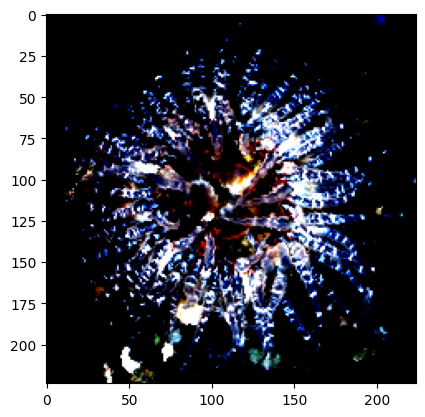

In [7]:
import matplotlib.pyplot as plt
import numpy as np

for i in train_loader:
    a , b = i
    print(a[15].shape)
    plt.imshow(np.transpose(a[0].numpy(), (1, 2, 0)))
    print(b[15])
    # print(i[0][0].shape)
    break

In [8]:


# Load pre-trained model
model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


In [9]:
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

conv1.weight: False
bn1.weight: False
bn1.bias: False
layer1.0.conv1.weight: False
layer1.0.bn1.weight: False
layer1.0.bn1.bias: False
layer1.0.conv2.weight: False
layer1.0.bn2.weight: False
layer1.0.bn2.bias: False
layer1.0.conv3.weight: False
layer1.0.bn3.weight: False
layer1.0.bn3.bias: False
layer1.0.downsample.0.weight: False
layer1.0.downsample.1.weight: False
layer1.0.downsample.1.bias: False
layer1.1.conv1.weight: False
layer1.1.bn1.weight: False
layer1.1.bn1.bias: False
layer1.1.conv2.weight: False
layer1.1.bn2.weight: False
layer1.1.bn2.bias: False
layer1.1.conv3.weight: False
layer1.1.bn3.weight: False
layer1.1.bn3.bias: False
layer1.2.conv1.weight: False
layer1.2.bn1.weight: False
layer1.2.bn1.bias: False
layer1.2.conv2.weight: False
layer1.2.bn2.weight: False
layer1.2.bn2.bias: False
layer1.2.conv3.weight: False
layer1.2.bn3.weight: False
layer1.2.bn3.bias: False
layer2.0.conv1.weight: False
layer2.0.bn1.weight: False
layer2.0.bn1.bias: False
layer2.0.conv2.weight: False
l

In [10]:
def validate(model, val_loader, criterion, device):
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        return val_loss / total, correct / total

In [11]:
def train_model(model, train_loader, val_loader, device,learning_rate=0.1, epochs=5,wandb=None ):
        model.to(device)
        criterion = torch.nn.CrossEntropyLoss().to(device)

        # criterion = torch.nn.CrossEntropyLoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)

        for epoch in tqdm(range(epochs), desc="Training Progress",position=0):
        # for epoch in range(epochs):
            model.train()
            running_loss, correct, total = 0.0, 0, 0

            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}",position=1):
            # for images, labels in train_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                # print(images.shape, labels.shape)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            train_loss = running_loss / total
            train_acc = correct / total

            val_loss, val_acc = validate(model , val_loader, criterion, device)

            if wandb:
                wandb.log({"train_loss": train_loss, "train_acc": train_acc,"val_loss": val_loss, "val_acc": val_acc})
            print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f},train_loss: {train_loss:.4f},val_loss: {val_loss:.4f}")

In [17]:
run = wandb.init(config =None,
                    project="DA6401_assignment2",)
    # run.mark_preempting()

    # with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
# config = wandb.config

wandb.run.name="Pretrained_Model,lr=0.00001,with augmentation"
wandb.run.save()
# train_loader, val_loader, test_loader, tiny_loader = get_dataloaders(data_dir, augment=config.augment)
# loader = build_dataset(config.batch_size)
set_seed(42)
train_model(model, train_loader, val_loader, device,learning_rate=0.00001, epochs=20,wandb=run )

run.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: Train Acc: 0.1576, Val Acc: 0.2175,train_loss: 2.2790,val_loss: 2.2015


Epoch 2/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2: Train Acc: 0.2667, Val Acc: 0.3470,train_loss: 2.1597,val_loss: 2.0829


Epoch 3/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3: Train Acc: 0.3864, Val Acc: 0.4715,train_loss: 2.0544,val_loss: 1.9769


Epoch 4/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4: Train Acc: 0.4624, Val Acc: 0.5335,train_loss: 1.9673,val_loss: 1.8766


Epoch 5/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5: Train Acc: 0.5143, Val Acc: 0.5905,train_loss: 1.8792,val_loss: 1.7902


Epoch 6/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6: Train Acc: 0.5528, Val Acc: 0.6040,train_loss: 1.8048,val_loss: 1.7167


Epoch 7/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7: Train Acc: 0.5747, Val Acc: 0.6185,train_loss: 1.7387,val_loss: 1.6481


Epoch 8/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8: Train Acc: 0.5952, Val Acc: 0.6310,train_loss: 1.6763,val_loss: 1.5833


Epoch 9/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9: Train Acc: 0.6032, Val Acc: 0.6455,train_loss: 1.6230,val_loss: 1.5129


Epoch 10/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10: Train Acc: 0.6167, Val Acc: 0.6575,train_loss: 1.5711,val_loss: 1.4658


Epoch 11/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11: Train Acc: 0.6260, Val Acc: 0.6665,train_loss: 1.5265,val_loss: 1.4263


Epoch 12/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12: Train Acc: 0.6292, Val Acc: 0.6690,train_loss: 1.4826,val_loss: 1.3863


Epoch 13/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13: Train Acc: 0.6360, Val Acc: 0.6705,train_loss: 1.4445,val_loss: 1.3416


Epoch 14/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14: Train Acc: 0.6387, Val Acc: 0.6800,train_loss: 1.4163,val_loss: 1.3095


Epoch 15/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15: Train Acc: 0.6436, Val Acc: 0.6840,train_loss: 1.3793,val_loss: 1.2792


Epoch 16/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 16: Train Acc: 0.6457, Val Acc: 0.6900,train_loss: 1.3543,val_loss: 1.2460


Epoch 17/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17: Train Acc: 0.6501, Val Acc: 0.6885,train_loss: 1.3255,val_loss: 1.2223


Epoch 18/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 18: Train Acc: 0.6485, Val Acc: 0.6925,train_loss: 1.3039,val_loss: 1.1957


Epoch 19/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 19: Train Acc: 0.6598, Val Acc: 0.6960,train_loss: 1.2788,val_loss: 1.1756


Epoch 20/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 20: Train Acc: 0.6558, Val Acc: 0.6965,train_loss: 1.2594,val_loss: 1.1526


train_acc,▁▃▄▅▆▇▇▇▇▇██████████
train_loss,█▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁
val_acc,▁▃▅▆▆▇▇▇▇▇██████████
val_loss,█▇▇▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁
train_acc,0.65583
train_loss,1.2594
val_acc,0.6965
val_loss,1.15258


In [14]:
# train_model(model, train_loader, val_loader, device,learning_rate=0.00001, epochs=20,wandb=None )


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: Train Acc: 0.1483, Val Acc: 0.2220,train_loss: 2.2890,val_loss: 2.2047


Epoch 2/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2: Train Acc: 0.2878, Val Acc: 0.3860,train_loss: 2.1442,val_loss: 2.0629


Epoch 3/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3: Train Acc: 0.4279, Val Acc: 0.5150,train_loss: 2.0196,val_loss: 1.9372


Epoch 4/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4: Train Acc: 0.5207, Val Acc: 0.5750,train_loss: 1.9074,val_loss: 1.8226


Epoch 5/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5: Train Acc: 0.5667, Val Acc: 0.6200,train_loss: 1.8085,val_loss: 1.7237


Epoch 6/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6: Train Acc: 0.6048, Val Acc: 0.6460,train_loss: 1.7210,val_loss: 1.6388


Epoch 7/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7: Train Acc: 0.6196, Val Acc: 0.6535,train_loss: 1.6438,val_loss: 1.5634


Epoch 8/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8: Train Acc: 0.6341, Val Acc: 0.6625,train_loss: 1.5754,val_loss: 1.4965


Epoch 9/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9: Train Acc: 0.6457, Val Acc: 0.6795,train_loss: 1.5123,val_loss: 1.4223


Epoch 10/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10: Train Acc: 0.6593, Val Acc: 0.6810,train_loss: 1.4584,val_loss: 1.3793


Epoch 11/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11: Train Acc: 0.6632, Val Acc: 0.6865,train_loss: 1.4080,val_loss: 1.3373


Epoch 12/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12: Train Acc: 0.6663, Val Acc: 0.6940,train_loss: 1.3681,val_loss: 1.2964


Epoch 13/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13: Train Acc: 0.6742, Val Acc: 0.6905,train_loss: 1.3237,val_loss: 1.2456


Epoch 14/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14: Train Acc: 0.6773, Val Acc: 0.7005,train_loss: 1.2890,val_loss: 1.2112


Epoch 15/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15: Train Acc: 0.6832, Val Acc: 0.7045,train_loss: 1.2554,val_loss: 1.1825


Epoch 16/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 16: Train Acc: 0.6820, Val Acc: 0.7105,train_loss: 1.2323,val_loss: 1.1530


Epoch 17/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17: Train Acc: 0.6900, Val Acc: 0.7105,train_loss: 1.2046,val_loss: 1.1267


Epoch 18/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 18: Train Acc: 0.6952, Val Acc: 0.7120,train_loss: 1.1787,val_loss: 1.0984


Epoch 19/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 19: Train Acc: 0.6970, Val Acc: 0.7185,train_loss: 1.1565,val_loss: 1.0838


Epoch 20/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 20: Train Acc: 0.7010, Val Acc: 0.7165,train_loss: 1.1365,val_loss: 1.0614


In [18]:
criterion = torch.nn.CrossEntropyLoss().to(device)
test_loss, test_acc = validate(model , test_loader, criterion, device)


In [19]:
test_loss, test_acc

(1.1628333024978639, 0.685)

In [29]:
# train_model(model, train_loader, val_loader, device,learning_rate=0.0001, epochs=10,wandb=None )


In [33]:
run = wandb.init(config = None,
                    project="DA6401_assignment2",)
    # run.mark_preempting()

    # with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
# config = wandb.config

wandb.run.name="Pretrained_Model,lr=0.00001"
wandb.run.save()
# train_loader, val_loader, test_loader, tiny_loader = get_dataloaders(data_dir, augment=config.augment)
# loader = build_dataset(config.batch_size)
# set_seed(42)
train_model(model, train_loader, val_loader, device,learning_rate=0.00001, epochs=20,wandb=run )

run.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: Train Acc: 0.1483, Val Acc: 0.2190,train_loss: 2.2728,val_loss: 2.1888


Epoch 2/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2: Train Acc: 0.3090, Val Acc: 0.3915,train_loss: 2.1316,val_loss: 2.0487


Epoch 3/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3: Train Acc: 0.4461, Val Acc: 0.5060,train_loss: 2.0072,val_loss: 1.9246


Epoch 4/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4: Train Acc: 0.5303, Val Acc: 0.5595,train_loss: 1.8978,val_loss: 1.8103


Epoch 5/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5: Train Acc: 0.5701, Val Acc: 0.6085,train_loss: 1.8010,val_loss: 1.7133


Epoch 6/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6: Train Acc: 0.6025, Val Acc: 0.6325,train_loss: 1.7152,val_loss: 1.6300


Epoch 7/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7: Train Acc: 0.6231, Val Acc: 0.6485,train_loss: 1.6369,val_loss: 1.5573


Epoch 8/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8: Train Acc: 0.6327, Val Acc: 0.6615,train_loss: 1.5726,val_loss: 1.4917


Epoch 9/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9: Train Acc: 0.6483, Val Acc: 0.6775,train_loss: 1.5108,val_loss: 1.4178


Epoch 10/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10: Train Acc: 0.6518, Val Acc: 0.6860,train_loss: 1.4557,val_loss: 1.3757


Epoch 11/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11: Train Acc: 0.6622, Val Acc: 0.6945,train_loss: 1.4075,val_loss: 1.3341


Epoch 12/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12: Train Acc: 0.6688, Val Acc: 0.7000,train_loss: 1.3660,val_loss: 1.2953


Epoch 13/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13: Train Acc: 0.6727, Val Acc: 0.7000,train_loss: 1.3235,val_loss: 1.2443


Epoch 14/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14: Train Acc: 0.6756, Val Acc: 0.7115,train_loss: 1.2889,val_loss: 1.2098


Epoch 15/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15: Train Acc: 0.6797, Val Acc: 0.7115,train_loss: 1.2558,val_loss: 1.1824


Epoch 16/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 16: Train Acc: 0.6776, Val Acc: 0.7130,train_loss: 1.2318,val_loss: 1.1527


Epoch 17/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17: Train Acc: 0.6828, Val Acc: 0.7125,train_loss: 1.2056,val_loss: 1.1276


Epoch 18/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 18: Train Acc: 0.6930, Val Acc: 0.7190,train_loss: 1.1797,val_loss: 1.0994


Epoch 19/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 19: Train Acc: 0.6921, Val Acc: 0.7260,train_loss: 1.1569,val_loss: 1.0845


Epoch 20/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 20: Train Acc: 0.6982, Val Acc: 0.7250,train_loss: 1.1373,val_loss: 1.0623


train_acc,▁▃▅▆▆▇▇▇▇▇██████████
train_loss,█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁
val_acc,▁▃▅▆▆▇▇▇▇▇██████████
val_loss,█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁
train_acc,0.69821
train_loss,1.13728
val_acc,0.725
val_loss,1.06228


In [60]:
# train_model(model, train_loader, val_loader, device,learning_rate=0.001, epochs=10,wandb=None )


In [15]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("dl2wandb")


In [16]:
wandb.login(key=secret_value_0)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True